In [ ]:
!pip install cplex
!apt install coinor-libipopt-dev
!pip install ipopt

In [ ]:
!pip install ibm_watson --upgrade

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import cplex
import cyipopt as ipopt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
from glob import glob
from bs4 import BeautifulSoup
import IPython
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from ibm_watson import SpeechToTextV1
from ibm_watson import AssistantV2
from ibm_watson import TextToSpeechV1

### Portfolio Strategies

In [ ]:
#“buy and hold” strategy
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init
    return x_optimal, cash_optimal

In [ ]:
#“Equally weighted” portfolio strategy
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    total_value = np.dot(cur_prices,x_init)+cash_init
    weight_optimal = np.array([1/len(x_init)]*len(x_init)) # Equal weight = 1/n
    allocated_value = weight_optimal*total_value
    
    x_optimal = np.floor(allocated_value/cur_prices) # Rounding procedure
    transaction_fee = 0.005 * np.dot(cur_prices,abs(x_optimal-x_init))
    cash_optimal = total_value - np.dot(cur_prices,x_optimal) - transaction_fee
    
    return x_optimal, cash_optimal

In [ ]:
#“Minimum variance” portfolio strategy
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    total_value = np.dot(cur_prices,x_init)+cash_init
    
    n = len(x_init)
    
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize) # Minimize objective
    c  = [0.0] * n # No linear objective
    lb = [0.0] * n
    ub = [1.0] * n
    
    Atilde = []
    for k in range(n):
        Atilde.append([[0,1],[1,0]]) # One column of ones times corresponding weights
    
    var_names = ["w_%s" % i for i in range(1,n+1)] 
    cpx.linear_constraints.add(rhs=[1.0,0], senses="EE")                  
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=Atilde, names=var_names)
    
    qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)] # Sparse matrix of Q
    cpx.objective.set_quadratic(qmat) # Quadratic objective
    cpx.parameters.threads.set(6)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    weight_optimal = np.array(cpx.solution.get_values())
    
    allocated_value = weight_optimal*total_value
    
    x_optimal = np.floor(allocated_value/cur_prices) #Rounding procedure
    transaction_fee = 0.005 * np.dot(cur_prices,abs(x_optimal-x_init))
    cash_optimal = total_value - np.dot(cur_prices,x_optimal) - transaction_fee
    
    return x_optimal, cash_optimal

In [ ]:
#“Maximum Sharpe ratio” portfolio strategy
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    total_value = np.dot(cur_prices,x_init)+cash_init
    
    n = len(x_init)+1
    r_rf = 0.025
    daily_rf = r_rf/252
    diff = mu - daily_rf
    
    coe_k = np.zeros((len(x_init),1))
    Q = np.hstack((Q,coe_k))
    coe_k = np.zeros((1,len(x_init)+1))
    Q = np.vstack((Q,coe_k)) # New row and column for risk free asset
    
    Atilde = []
    for k in range(len(x_init)):
        Atilde.append([[0,1],[diff[k],1]])
    Atilde.append([[0,1],[0,-1]]) 
    
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [np.inf] * n 
    
    var_names = ['y_%s'% i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0,0],senses='EE')
    cpx.variables.add(obj=c,lb=lb,ub=ub,columns=Atilde,names=var_names)

    qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(qmat) # Quadratic objective
    cpx.parameters.threads.set(6)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    
    w_maxSharpe = np.array(cpx.solution.get_values()) # Optimal weight                        
    weight = w_maxSharpe[0:len(x_init)]/w_maxSharpe[len(x_init)]
    
    allocated_value = weight*total_value
    
    x_optimal = np.floor(allocated_value/cur_prices) # Rounding procedure
    transaction_fee = 0.005 * np.dot(cur_prices,abs(x_optimal-x_init))
    cash_optimal = total_value - np.dot(cur_prices,x_optimal) - transaction_fee
    
    return x_optimal, cash_optimal

In [ ]:
#“Equal risk contribution” portfolio strategy
def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    
    portfolio_value = np.dot(cur_prices,x_init) + cash_init
    
    class erc(object):
        def __init__(self):
            pass

        def objective(self, x):
            # The callback for calculating the objective
            y = x * np.dot(Q, x)
            fval = 0
            for i in range(n):
                for j in range(i,n):
                    xij = y[i] - y[j]
                    fval = fval + xij*xij
            fval = 2*fval
            return fval

        def gradient(self, x):
            # The callback for calculating the gradient
            grad = np.zeros(n)
            y = x * np.dot(Q, x)
            #  use finite differences to check the gradient
            for i in range(n):
                for j in range(n):
                    diff1 = np.dot(Q[i],x) + np.dot(Q[i][i],x[i])
                    diff2 = np.dot(Q[i][j], x[i])
                    delta_g = (y[i]-y[j]) * (diff1 - diff2)
                    grad[i] = grad[i] + delta_g
                grad[i] = 2 * 2 * grad[i]
            return grad

        def constraints(self, x):
        # The callback for calculating the constraints
            return [1.0] * n
    
        def jacobian(self, x):
        # The callback for calculating the Jacobian
            return np.array([[1.0] * n])
    
    n = len(x_init)
    w0 = (x_init*cur_prices)/portfolio_value # initial weight distribution
    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints
    
    
    # Define IPOPT problem
    nlp = ipopt.Problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
    
    # Set the IPOPT options
    nlp.add_option('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.add_option('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.add_option('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.add_option('tol'.encode('utf-8'), 1e-10)
    nlp.add_option('print_level',0)
    
    
    w_optimal, info = nlp.solve(w0)
    
    allocated_money = w_optimal * portfolio_value
    x_optimal = np.floor(allocated_money/cur_prices)                                 #Convert the weight optimal to position optimal        
    transaction_fee = np.dot(cur_prices, abs(x_optimal-x_init))*0.005               #0.5% of transaction cost
    cash_optimal = portfolio_value - np.dot(cur_prices,x_optimal) - transaction_fee #cash = asset - stock value- transaction cost
 
    return x_optimal, cash_optimal

In [ ]:
#“Robust mean-variance optimization” portfolio strategy
def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
    portfolio_value = np.dot(cur_prices,x_init) + cash_init
    n = len(x_init)
    w0 = [1/n]*n                                         # Weight distribution for 1/n portfolio
    var_matr = np.diag(np.diag(Q))                           # Required portfolio robustness
    rob_init = np.dot(w0, np.dot(var_matr, w0))              # return estimation error of 1/n portfolio
    rob_bnd  = rob_init                                      # Target portfolio return estimation error is return estimation error of 1/n portfolio
    r_rf = 0.025
    daily_rf = r_rf/252
    Portf_Retn = daily_rf                                  
    
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
      
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n
    Atilde = []
    for k in range(n):
        Atilde.append([[0,1],[1.0,mu[k]]])
    var_names = ["w_%s" % i for i in range(1,n+1)]
    
    cpx.linear_constraints.add(rhs=[1.0,Portf_Retn], senses="EG")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=Atilde, names=var_names)
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    Qcon = cplex.SparseTriple(ind1=var_names, ind2=range(n), val=np.diag(var_matr))
    cpx.quadratic_constraints.add(rhs=rob_bnd, quad_expr=Qcon, name="Qc")
    cpx.parameters.threads.set(4)
    cpx.parameters.timelimit.set(60)
    cpx.parameters.barrier.qcpconvergetol.set(1e-12)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    
    w_rMV = cpx.solution.get_values()
    # Round near-zero portfolio weights
    w_rMV = np.array(w_rMV)
    w_rMV[w_rMV<1e-6] = 0
    w_optimal = w_rMV / np.sum(w_rMV)
    
    allocated_money = w_optimal*portfolio_value
    x_optimal = np.floor(allocated_money/cur_prices)                                 # Convert weight optimal to postion optimal(x_optimal
    transaction_fee = np.dot(cur_prices, abs(x_optimal-x_init))*0.005                #0.5% of transaction cost
    cash_optimal = portfolio_value - np.dot(x_optimal,cur_prices) - transaction_fee #cash = asset - stock value- transaction cost

    return x_optimal, cash_optimal

### Portfolio Optimization Selection

##### All the dataset used are in the folder "Data". Please download and implement the files before running the code

In [ ]:
def get_portfolio(industry, cur_cash):
    print('Stocks are chosen from {} industry'.format(industry))
    input_file = industry +'.csv'
    df = pd.read_csv(input_file)
    
    data_prices = df.iloc[:, 1:].to_numpy()
    cur_returns0 = data_prices[1:,:] / data_prices[:-1,:] - 1
    mu = np.mean(cur_returns0, axis = 0)
    Q = np.cov(cur_returns0.T)
    
    init_positions = np.ones(df.shape[1]-1)
    
    # Initial value of the portfolio
    init_value = np.dot(data_prices[0,:], init_positions)

    # Initial portfolio weights
    w_init = (data_prices[0,:] * init_positions) / init_value
    
    # Number of assets
    N = len(df.columns)-1

    # Annual risk-free rate for years 2020-2021 is 2.5%
    r_rf = 0.025

    # Number of strategies
    strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 
                          'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_robust_optim']
    strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio', 
                          'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']

    N_strat = len(strategy_functions)  
    fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, 
                strat_max_Sharpe, strat_equal_risk_contr, strat_robust_optim]

    portf_value = [0] * N_strat
    w_opt = np.zeros((N_strat,1),  dtype=np.ndarray)
    x = np.zeros((N_strat,1),  dtype=np.ndarray)
    cash = np.zeros((N_strat,1),  dtype=np.ndarray)

    cur_prices = data_prices[-1,:]

    for strategy  in range(N_strat):
        period = 1
        curr_cash = cur_cash 
      
        # Compute strategy
        x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](init_positions, curr_cash, mu, Q, cur_prices)

        # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
        # Check that cash account is >= 0
        # Check that we can buy new portfolio subject to transaction costs

        if cash[strategy, period-1] < 0:
            portfolio_V = np.dot(cur_prices,init_positions) + curr_cash
            
            ratio = x[strategy, period-1]/sum(x[strategy, period-1])
            neg_cash = abs(cash[strategy][period-1])*ratio
            neg_position = np.ceil(neg_cash/cur_prices)
            x[strategy][period-1] = x[strategy][period-1] - neg_position
            new_tran_cost = np.dot(cur_prices , abs(x[strategy, period-1]-init_positions)) * 0.005
            cash[strategy, period-1] = portfolio_V - np.dot(cur_prices,x[strategy, period-1]) - new_tran_cost
            
        # Compute portfolio value
        p_values = np.dot(data_prices, x[strategy, period-1]) + cash[strategy, period-1]
        portf_value[strategy] = np.reshape(p_values, (p_values.size,1))
        w_opt[strategy][period-1] = x[strategy, period-1] *cur_prices / np.dot(cur_prices,x[strategy, period-1])
#         print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
#              portf_value[strategy][0][0], portf_value[strategy][-1][0]),'\n')
#         print('  Strategy "{0}", optimal weight = "{1}"'.format( strategy_names[strategy], 
#              w_opt[strategy][0]),'\n')
    return df, portf_value, w_opt

In [ ]:
risk_dict = {"1": ['Buy and Hold','Minimum Variance Portfolio'],
            "2": ['Equally Weighted Portfolio','Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio'],
            "3":['Maximum Sharpe Ratio Portfolio']}

In [ ]:
def get_strategy (portf_value, key):
    strategy_list = risk_dict[key]
    strategy_names = ['Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio', 
                    'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 
                      'Robust Optimization Portfolio']

    index_list = [strategy_names.index(strategy) for strategy in strategy_list]
    
    for i in index_list:
        print("The strategy:",strategy_names[i],", the portfolio value is: {:.4f}".format(portf_value[i][-1][0]))
    
    ind = np.argmax([portf_value[index_list[i]][-1][0] for i in range(len(index_list))])
    print('\n')
    print("The strategy with the highest return is:", strategy_list[ind])
    
    return strategy_names.index(strategy_list[ind])

In [ ]:
def draw_plot(df,strategy,w_opt):
    
    idx = np.arange(w_opt[strategy][0].size)[w_opt[strategy][0] != 0]
    idx = idx[np.argsort(-w_opt[strategy][0][idx])]
    
    strategy_names= ['Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio', 
                     'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 
                     'Robust Optimization Portfolio']
    if df.shape[1] == 16:
      fig = plt.figure(figsize=(16,16))
    else:
      fig = plt.figure(figsize=(20,20))

    cmap= plt.get_cmap('tab20c')
    outer_colors = cmap(np.arange(15))
    
    plt.text(0, 1.2, strategy_names[strategy], fontsize=18, fontweight='bold',  horizontalalignment='center')
    
    plt.pie(x=w_opt[strategy][0][idx], colors=outer_colors, wedgeprops=dict(width=0.3),autopct='%1.1f%%')
    
    plt.legend(df.columns.values[1:][idx], loc="upper center", bbox_to_anchor=(-0.15, 1))

### Connect with the IBM Watson Assistant

In [ ]:
# Connect with the IBM Watson Assistant
assistant = AssistantV2(version='2021-11-27', authenticator=IAMAuthenticator('0WShgymFdSMaq-VW3vhpIST-8jS0yQODfOIgIb7nzyTi'))
assistant.set_service_url('https://api.us-east.assistant.watson.cloud.ibm.com/instances/148df814-f842-40a3-9d99-f6060d92c491')
ASSISTANT_ID = "655cf659-b986-438d-a455-769b30656f77"
session_id = assistant.create_session(assistant_id=ASSISTANT_ID).get_result()["session_id"]

def message_assistant(text):
    response = assistant.message(assistant_id=ASSISTANT_ID,
                                 session_id=session_id,
                                 input={'message_type': 'text', 'text': text}).get_result()
    return BeautifulSoup(response["output"]["generic"][0]["text"]).get_text()

In [ ]:
def EasyInvestment():
    while True:
        ans = input().lower()

        # risk level
        if ans in [s.lower() for s in ["I know nothing about investment","I'm new", "I'm new to investing", "I'm new to investment", "I'm new to the investing", 
                      "Less", "Less Risk", "Level 1", "Level1", "Level 1(Less Risk)", "Low", 
                      "I would withdraw all of my money", "I would withdraw some of my money", "withdraw all of my money", "withdraw some of my money","withdraw all", "withdraw some"]]:
            risk_level = '1'
        elif ans in [s.lower() for s in ["Level 2", "Level2", "Level 2(Medium Risk)", "medium", "medium risk",
                      "I'd stay invested, but wouldn't add more", "stay invested"]]:
            risk_level = '2'
        elif ans in [s.lower() for s in ["High", "high risk", "Level 3", "Level3", "Level 3(More Risk)",
                      "I'd add more","I would keep adding to my investment","keep adding", "add more"]]:
            risk_level = '3'

        # industry
        if ans in [s.lower() for s in ["Agriculture", "farm"]]:
            industry = 'Agriculture'
        elif ans in [s.lower() for s in ["Finance", "Finance and Insurance", "Insurance"]]:
            industry = 'Finance'
        elif ans in [s.lower() for s in ["Health", "Healthcare", "Medical"]]:
            industry = 'Healthcare'
        elif ans in [s.lower() for s in ["Tech", "Technology"]]:
            industry = 'Technology'
        elif 'no' in ans:
            industry = 'All'

        # cash (with k)
        if ans in ["100k", "10k", "1k", "5k", "50k"]:
            cur_cash = int(ans[:-1]+"000")

        print(message_assistant(ans))

        if 'Well done!' in message_assistant(ans):

            df, p , w = get_portfolio(industry,cur_cash)
            ind = get_strategy(p,risk_level)
            draw_plot(df,ind,w)

            break

### Testing

hi
Hi, nice to meet you! I am your personal investment bot. I am here to offer investment suggestions for your needs. Let's make some money together!
ok
Now, let's begin! What's the main reason you are investing? Choose from the following options: Retirement, Education, Future Purchases, or I do not know.
education
When will the fund be needed? Choose from: In 0-3 years, In 4-5 years, In 6-10 years, More than 10 years.
0-3
What is your income level this year? Choose from: 0-40k, 40k-80k, 80k-120k, 120k-200k, More than 200k. (CAN)
40-80
How much do you know about investing? Choose from: I'm new to investing, I understand the basics, I've got a good understanding, I'm an investing expert
i'm new
Welcome to the investment world! Now let's imagine if you lost 30% of your  investment over the next year, what would you do? Choose from: I would withdraw all of my money; I would withdraw some of my money; I'd stay invested, but wouldn't add more; I would keep adding to my investment.
stay inve

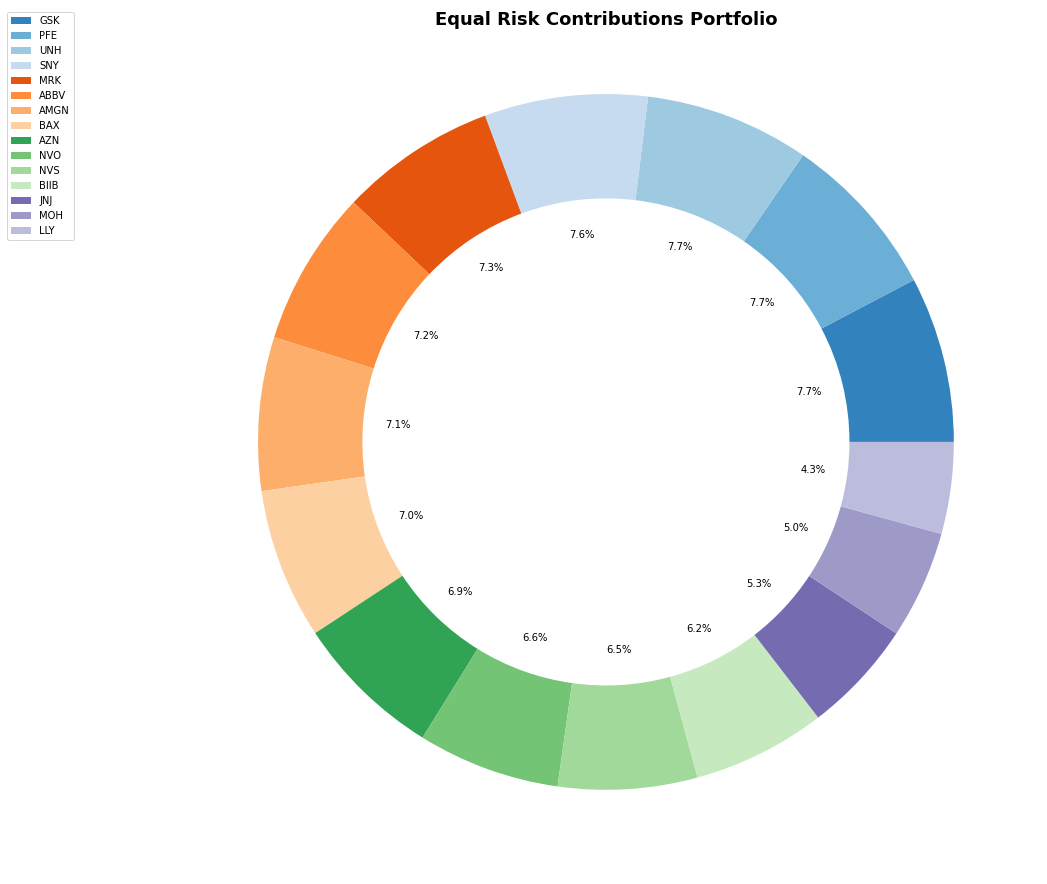

In [ ]:
EasyInvestment()